![logo](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/Helmholtz-AI.png?raw=true)

# Model-Agnostic Interpretation with SHAP

In this Notebook, we will demonstrate how to use the SHapley Additive exPlanations (SHAP) method and interpret its results.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. To start working on the notebook, click on the following button. This will open this page in the Colab environment, and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/xai-for-random-forest/Bio-3-Tutorial_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Google Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive, and you can navigate it through the lefthand panel in Colab. You might also have received an email that informs you about the access on your Google Drive.

In [1]:
# Mount drive folder to dbe abale to download repo
# from google.colab import drive
# drive.mount('/content/drive')

# Switch to correct folder'
# %cd /content/drive/MyDrive

In [ ]:
# Don't run this cell if you already cloned the repo 
# %rm -r XAI-Tutorials
# !git clone --branch main https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git

In [ ]:
# %cd XAI-Tutorials
# !pip install -r requirements_xai-for-random-forest.txt
# %cd xai-for-random-forest

### Imports

Let's start with importing all required Python packages.

In [4]:
import sys
import shap
import pickle

import numpy as np
import pandas as pd

from sklearn.metrics import balanced_accuracy_score

sys.path.append('./')
import utils

Now, we fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [5]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

--------

## Data and Model Loading: The Wisconsin Breast Cancer Dataset

In this notebook, we will work with the **Wisconsin Breast Cancer dataset**, containing 569 samples of 212 malignant and 357 benign tumors. Tumors are described by 30 numeric features computed from a digitized image taken of breast mass (for more details please see descrption [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)).

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_breastcancer.png?raw=true" width="700" /></center>

<font size=1> Source: [Link](https://www.kaggle.com/code/midouazerty/breast-cancer-prediction-99)

In the notebook [*Bio-0-Tutorial_RandomForest_Model_BreastCancer.ipynb*](./Bio-0-Tutorial_RandomForest_Model_BreastCancer.ipynb), we explain how to do the exploratory data analysis, preprocess the data and train a Random Forest model with the given data. The focus of this notebook is the interpretation of the previously trained model.

In [6]:
# Load and unpack the data
with open('../models/model_rf_breastcancer.pickle', 'rb') as handle:
    data_and_model = pickle.load(handle)

X_train = data_and_model[0]
X_test = data_and_model[1]
y_train = data_and_model[2]
y_test = data_and_model[3]
model_breastcancer = data_and_model[4]

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(balanced_accuracy_score(y_train, model_breastcancer.predict(X_train))*100,2)} % balanced accuracy.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(balanced_accuracy_score(y_test, model_breastcancer.predict(X_test))*100,2)} % balanced accuracy.')

Model Performance on training data: 100.0 % balanced accuracy.
Model Performance on test data: 94.05 % balanced accuracy.


As we can see by the numbers above, our model performs well on the training set and also generalizes well to the independent test set.

**You should keep in mind that interpreting a low-performing model can lead to wrong conclusions.**

--------

## Now, what does my model think is important in the data?

### SHapley Additive exPlanations (SHAP)

**We prepared a small [Introduction to SHAP](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/shap.html) for you, to help you understand how this method works.**

*Note: we provide all references [here](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/shap.html#references).*

<font color='green'>

#### Question 1: What does the Shapley value tell you about the effect of the feature on a prediction?

<font color='grey'>

#### Your Answer: 
It tells you by how much the specific feature is moving the sample’s prediction away from the mean prediction of all samples.


<font color='green'>

#### Question 2: What are the differences between the permutation importance method?

<font color='grey'>

#### Your Answer: 
- The Shapley value itself tells you something about the absolute effect of a feature on the output.
- To get the importance of a feature all possible combinations of feature subsets with and without the feature of interest are computed.
- Shapley is based only on model prediction and not on performance metrics.


<font color='green'>

#### Question 3: What is the main limitation of Shapley values and why?

<font color='grey'>

#### Your Answer: 
It is computationally expensive, especially for large models and large feature sets, as you need to compute all possible combinations of features. Also problems with complex correlations.

Now let's use SHAP to get insights into the Random Forest Regression model we loaded above. The `shap.Explainer()` function computes the SHAP values for any machine learning model. If your dataset is large, you might want to use a subset of your original training data, as the SHAP value calculation takes some time. Since our model is a Random Forest model, we use TreeSHAP, which calculates Shapley values for tree-based methods in a fast and model-specific way ([Lundberg et al. 2020](https://doi.org/10.1038/s42256-019-0138-9), [Mitchell 2022](https://doi.org/10.48550/arXiv.2010.13972)) and allows us to use the whole dataset with short computation time. Please refer to the [SHAP API](https://shap.readthedocs.io/en/latest/api.html#explainers) for alternative explainers.

*Note: This method is a local method, meaning it only provides explanations for individual samples. However, the individual explanations can be used to also get global interpretations.*

### TreeShap for Classification Models

We compute the SHAP values using `shap.TreeExplainer` which implements the TreeSHAP method. The SHAP values explain why a prediction for a single observation differs from the average prediction for all the observations in the data set.  

In [7]:
# run SHAP
explainer = shap.TreeExplainer(model_breastcancer)

# average prediction for the dataset
pm = np.mean(model_breastcancer.predict_proba(X_train), axis=0)

print(f'Models average prediction for our data set is for class 0: {round(pm[0],3)}, for class 1: {round(pm[1],3)}')
print(f'Expected value for our data set is for class 0: {round(explainer.expected_value[0],3)}, for class 1: {round(explainer.expected_value[1],3)}')

Models average prediction for our data set is for class 0: 0.627, for class 1: 0.373
Expected value for our data set is for class 0: 0.497, for class 1: 0.503


As you can notice form the numbers above, the model's average prediction and the SHAP expected value differ for both classes. Why is that the case?  
When using TreeExplainer for a Ranfom Forest model, there will be small variations between the average model prediction and the expected value from SHAP. This behaviour is explained as follows in this [GitHub thread](https://github.com/shap/shap/issues/318#issuecomment-437429986):

> It is because of how sklearn records the training samples in the tree models it builds. Random forests use a random subsample of the data to train each tree, and it is that random subsample that is used in sklearn to record the leaf sample weights in the model. Since TreeExplainer uses the recorded leaf sample weights to represent the training dataset, it will depend on the random sampling used during training. This will cause small variations like the ones you are seeing.

To get the exact same values, we provide a background dataset for integrating out features. This dataset has to be passed to an Independent masker, which correctly subsamles the data (otherwise only the first 100 samples are subsampled and the expected value might show high variations).

In addition, when using SHAP to explain a classifiers output, the default value in TreeExplainer for `model_output="raw"`, which explains the raw output of the model. For regression models, "raw" is the standard output. For classification this is the log odds ratio. We can set the `model_output="probability"` explaining the output of the model transformed into probability space, i.e. SHAP values now sum to the probability output of the model.

In [8]:
# run SHAP with background data and masker
explainer = shap.TreeExplainer(model=model_breastcancer, data=shap.maskers.Independent(X_train, max_samples=len(X_train)), model_output="probability")

# average prediction for the dataset
print(f'Models average prediction for our data set isfor class 0: {round(pm[0],3)}, for class 1: {round(pm[1],3)}')
print(f'SHAP expected value isfor class 0: {round(explainer.expected_value[0],3)}, for class 1: {round(explainer.expected_value[1],3)}')

Models average prediction for our data set isfor class 0: 0.627, for class 1: 0.373
SHAP expected value isfor class 0: 0.627, for class 1: 0.373


For classification task, shap explainer produces two expected values, corresponding to the average probability for each class, which is essentially the class frequency in the dataset. 

Now, we can retrieve the SHAP values for our dataset and process them for the visualizations. 

In [9]:
shap_values = explainer(X_train)

# round values and add feature names for plotting
shap_values.data = X_train.round(4) 

#NOTE: the new SHAP package is still a bit buggy.
#      the returned dimensions for the shaply value
#      matrix are swapped. Hence, we need to put
#      then into correct order first.
shap_values.values = list(np.transpose(shap_values.values,(2,0,1)))

Notice that the shapley values matrix is the same size as our input matrix that contains all the feature values for each observation (i.e., each row of the matrix). That means there is one Shapley value for each entry in our feature matrix. Hence, each observation (row) has a Shapley value for each of its features (columns) that explains that feature's contribution to the model's prediction for that observation.

In [10]:
print('Features matrix - # samples: {}, # features: {}'.format(X_train.shape[0], X_train.shape[1]))
print('SHAP values matrix - # samples: {}, # features: {}'.format(shap_values.values[0].shape[0], shap_values.values[0].shape[1]))

Features matrix - # samples: 455, # features: 30
SHAP values matrix - # samples: 455, # features: 30


One major difference when analysing classification models with SHAP, compared to regression models, is that we will get one shapley value matrix and expected value per class. Hence, in our case we will get two SHAP value matrices and expected values because we have two classes in the dataset. 

*Note: the order of the SHAP value matrices and expected value output is the same as the sorting of the target classes.*

### Local Explanations with SHAP

The SHAP package provides several visualizations that help us understand how each feature contributes to an individual prediction. Let's look at the prediction for a single observation (row) in our data set.

In [11]:
observation_of_interest = 1
print(f'For observation of interest {observation_of_interest} the target value is {y_train[observation_of_interest]}; and models prediction for the observation of interest: {model_breastcancer.predict(X_train)[observation_of_interest]}')

For observation of interest 1 the target value is 1_Cancer; and models prediction for the observation of interest: 1_Cancer


#### Force Plot

The force plot visualizes each feature's effect on the prediction for our single observation, given the current set of feature values. We have red forces which shift the prediction value ($f(x)$) to a higher value and blue forces which shift the prediction value to a lower value. This plots helps to understand which features ("forces") contribute to the difference between the average prediction and the actual prediction of our observation of interest for each class. The features closest the actual prediction value ($f(x)$) have the higest impact on the model's prediction. This plot is useful when the number of features is not too high. For an application example on medical data see [Lundberg et al. 2018](https://rdcu.be/baVbR)

*Note: The Shapley value can be misinterpreted. The Shapley value of a feature value is not the difference of the predicted value after removing the feature from the model training. The interpretation of the Shapley value is: Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.*

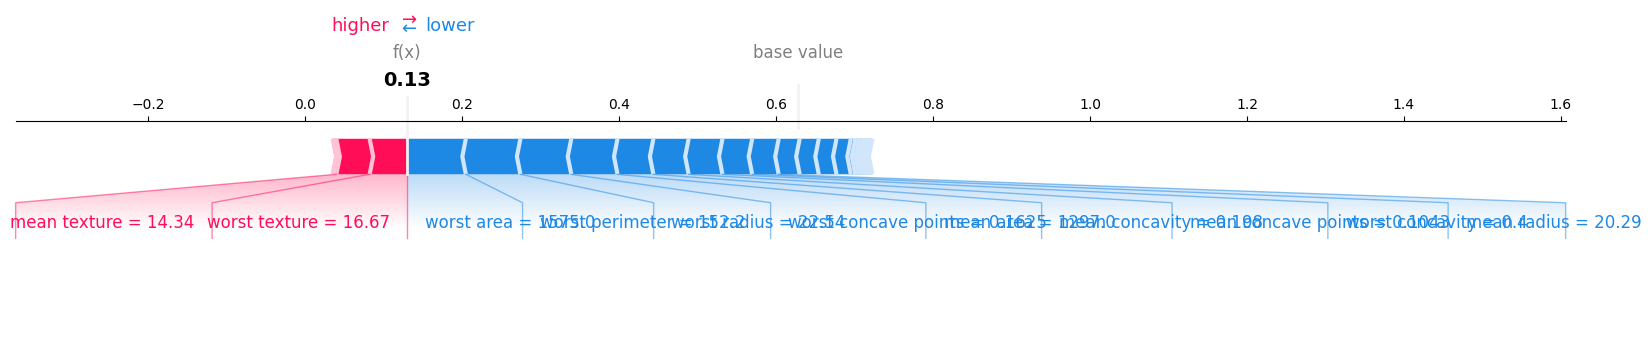

In [12]:
# force plot for class 0
target_class = 0
shap.force_plot(
    explainer.expected_value[target_class], 
    shap_values.values[target_class][observation_of_interest], 
    shap_values.data.iloc[observation_of_interest], 
    matplotlib=True)

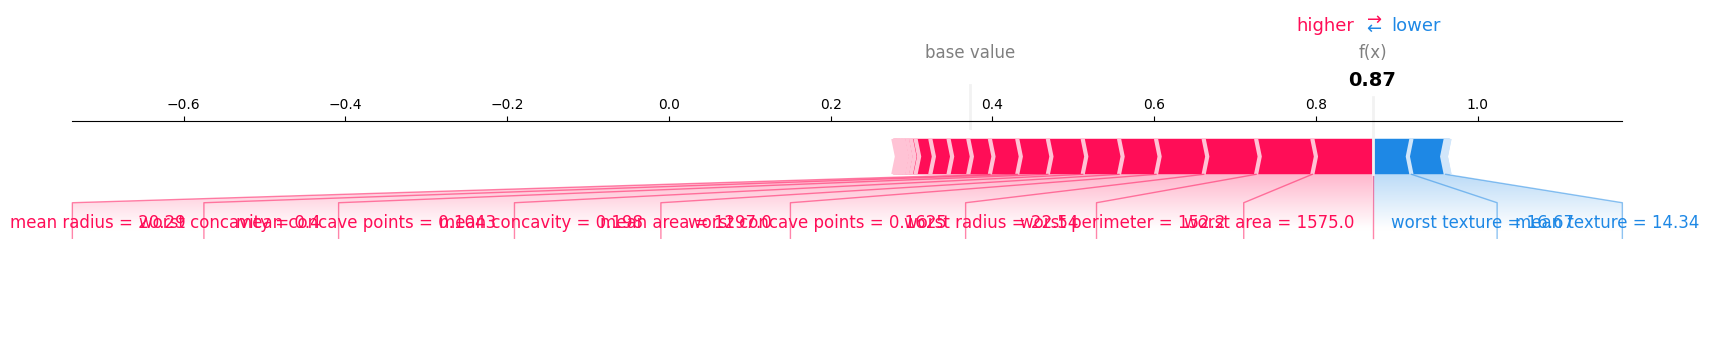

In [13]:
# force plot for class 0
target_class = 1
shap.force_plot(
    explainer.expected_value[target_class], 
    shap_values.values[target_class][observation_of_interest], 
    shap_values.data.iloc[observation_of_interest], 
    matplotlib=True)

We plot one force plot per class (class 0: control, class 1: cancer) for our obervation of interest, which is a cancer patient that has been classified as "cancer". 

In the first plot, we get the feature contributions to the predicted probability of belonging to the control class, which is 13% ($f(x)=0.13$). The average predicted probability for control class is however 62%. The force plot now indicates which features contribute to the difference between the predicted value of 13% and the expected value of 62%. We can see that the features *worst area* and *worst perimeter* are the top contributers to a lower predicted probability, whereas the feature *worst texture* and *mean texture* contribute to a higher predicted probability.  

In the second plot we have the same information for the predicted probability of belonging to the cancer class, which is 87% ($f(x)=0.87$). We see that the forces are basically reversed, where the features that contributed most to a lower predicted probability in the first plot now contribute the most to a higher predicted probability in the second plot.

The SHAP package also provides decision plots, waterfall plots and other plots for visualizing local explanations. For more information on the different plots see [here](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html).

### Global Explanations with SHAP

#### Global Bar Plots

The local explanation plots are great for looking at the model's predictions with granularity. But what if we want a simple summary of how important each feature is in making predictions for the entire data set - something like *feature importance*?

The SHAP package covers this case by providing a global feature importance plot, where the global importance of each feature is taken to be the mean absolute SHAP value for that feature over all the given samples stacked per class. 

*Note: the shap.plots.bar() function of the new package does currently not work for classification problems. Instead, we have to use the old shap.summary_plot() function.*

/var/folders/8g/7wdchs993770j0nbzbt5p0_r0000gn/T/ipykernel_8300/3206266506.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


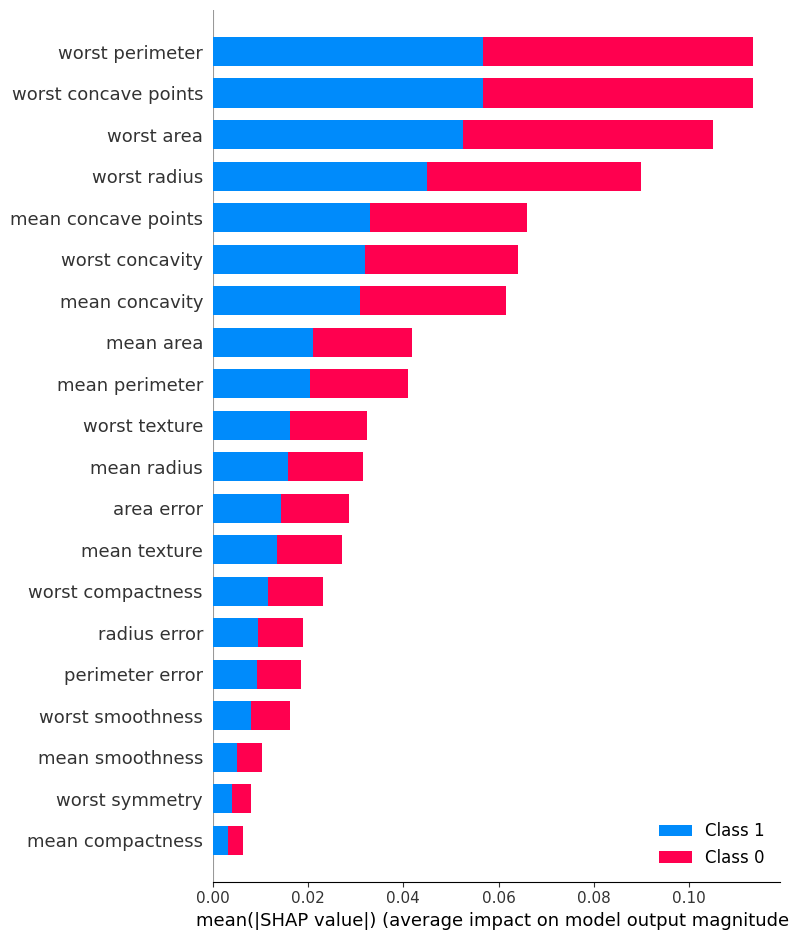

In [14]:
shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    plot_type='bar')

Just to make sure we understand what's happening here. Remember, each row is an observation representing a patient, and we have 455 patients. Each column is a feature, and there are 30 features. All we did in the calculation above was to average all the (absolute values of the) 455 SHAP values in each column. That gives us 30 sums, one for each feature, and those are our 30 feature importances for this model (only 20 plotted above). It's that simple.

Let's pause and consider this for a moment because this is a really important point: the feature importance for the entire model is calculated directly from their importance for individual observations. In other words, the importance is consistent between the model's global and local behavior. This consistency is a remarkable and really important characteristic that many model interpretability methods do not offer.

The SHAP package also provides local bar plots, bar plots separated by cohorts or ordered by feature clustering. For more information on the different bar plots see [here](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html).

#### Beeswarm

The SHAP package also provides a more granular look at feature importances for the entire data set. When we want to visualize the SHAP value summary as a beeswarm, we have to do the visualization class-wise again.

*Note: the shap.plots.beeswarm() function of the new package does currently not work for classification problems. Instead, we have to use the old shap.summary_plot() function.*

/var/folders/8g/7wdchs993770j0nbzbt5p0_r0000gn/T/ipykernel_8300/1448840610.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


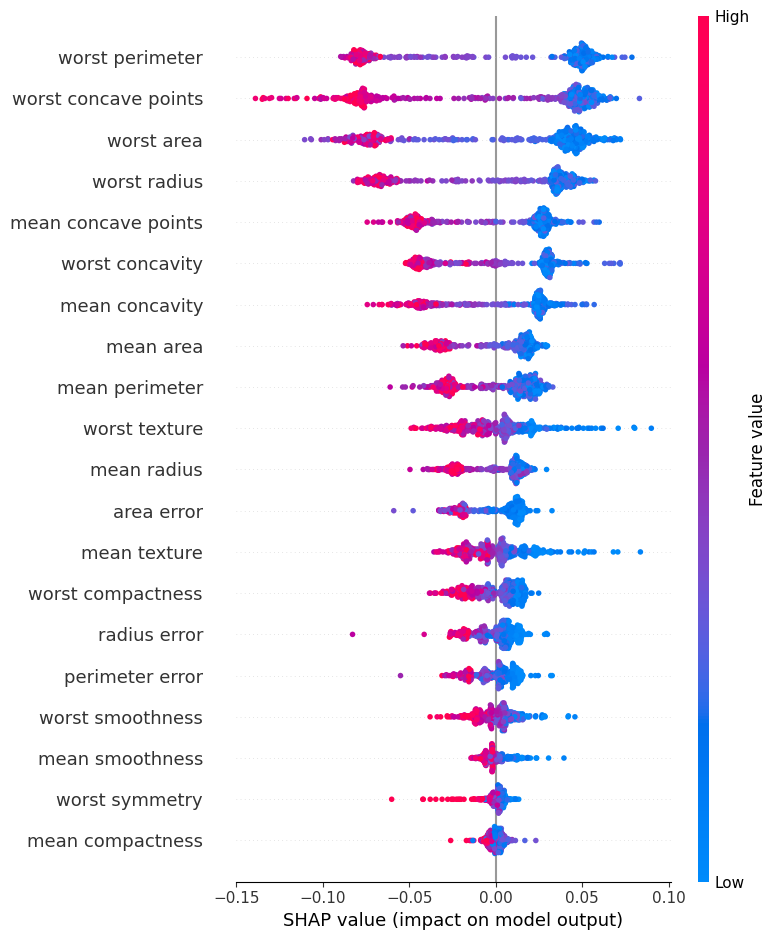

In [15]:
# summary plot for class 0
target_class = 0
shap.summary_plot(
    shap_values.values[target_class], 
    shap_values.data)

/var/folders/8g/7wdchs993770j0nbzbt5p0_r0000gn/T/ipykernel_8300/1464221216.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


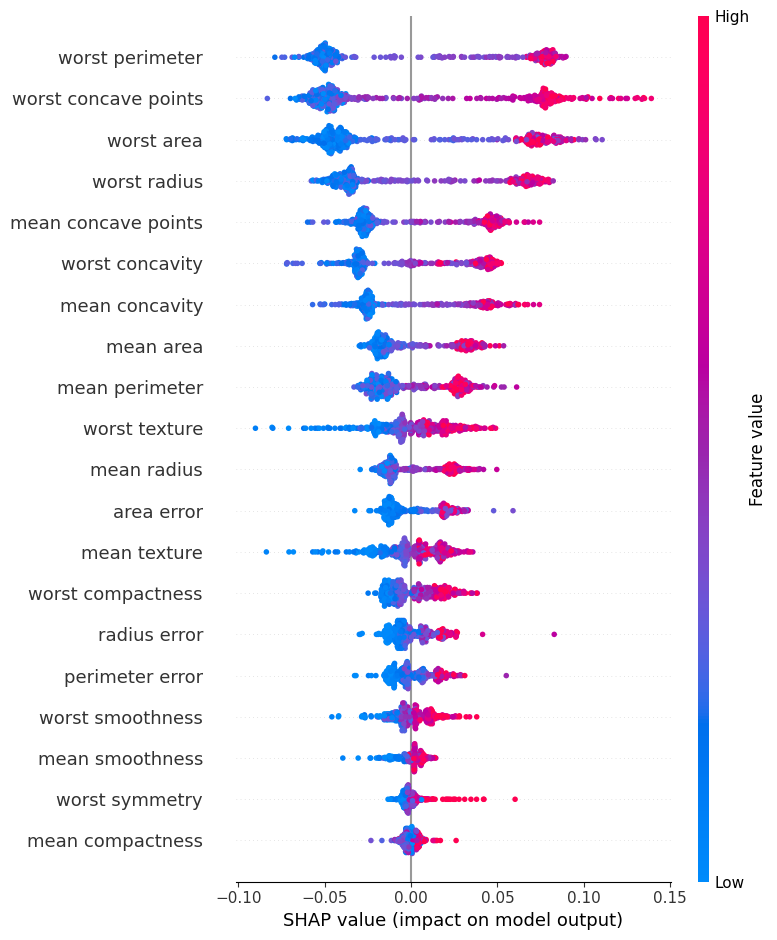

In [16]:
# summary plot for class 0
target_class = 1
shap.summary_plot(
    shap_values.values[target_class], 
    shap_values.data)

The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model’s output. Here, the Shapley values of every observation are plotted for each feature. Additionally, the coloring indicates whether low (or high) values of each feature increase (or decrease) the model's predictions. For example, we can see that low value for *worst perimeter*, *worst concave points*, *worst area* and *worst radius* increases the probability of being predicted as control (i.e., the Shapley values are greater than zero).

--------

### Dealing with Correlated Features

In the introduction video you already learned that computing SHAP values comes along with the assumption that the features are independent - an assumption that is broken in the presence of high feature correlations.

So, let's have a look of the amount of correlation we exhibit in our dataset.

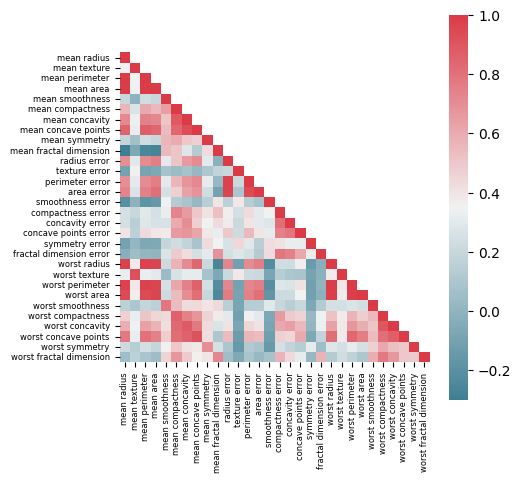

In [17]:
utils.plot_correlation_matrix(X_train, figsize=(5,5), annot=False, labelsize=6)

Looking at the correlation matrix above, we notice that we have a lot of correlation among features in our dataset. For instance, the top scored feature *worst perimeter* is highly correlated to many other features in the dataset.  

To showcase the effect of correlation on the feature importance analysis, we will load a second Random Forest model that was trained on selected set of uncorrelated features. 

In [18]:
# Load and unpack the data
with open('../models/model_rf_breastcancer_sel.pickle', 'rb') as handle:
    data_and_model = pickle.load(handle)

X_train_sel = data_and_model[0]
X_test_sel = data_and_model[1]
y_train_sel = data_and_model[2]
y_test_sel = data_and_model[3]
model_breastcancer_sel = data_and_model[4]

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(balanced_accuracy_score(y_train_sel, model_breastcancer_sel.predict(X_train_sel))*100,2)} % balanced accuracy.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(balanced_accuracy_score(y_test_sel, model_breastcancer_sel.predict(X_test_sel))*100,2)} % balanced accuracy.')

Model Performance on training data: 98.36 % balanced accuracy.
Model Performance on test data: 89.38 % balanced accuracy.


Next, we compute the SHAP values for the Random Forest Classifier trained on the selected feature set and then visualize the SHAP values.

Features matrix - # samples: 455, # features: 5
SHAP values matrix - # samples: 455, # features: 5


/var/folders/8g/7wdchs993770j0nbzbt5p0_r0000gn/T/ipykernel_8300/869529318.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


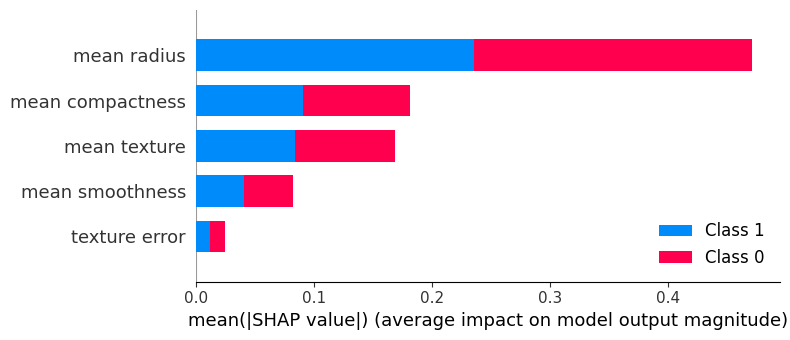

In [19]:
# run SHAP with background data and masker
explainer = shap.TreeExplainer(model=model_breastcancer_sel, data=shap.maskers.Independent(X_train_sel, max_samples=len(X_train_sel)), model_output="probability")

shap_values = explainer(X_train_sel)

# round values and add feature names for plotting
shap_values.data = X_train_sel.round(4) 

#NOTE: the new SHAP package is still a bit buggy.
#      the returned dimensions for the shaply value
#      matrix are swapped. Hence, we need to put
#      then into correct order first.
shap_values.values = list(np.transpose(shap_values.values,(2,0,1)))

print('Features matrix - # samples: {}, # features: {}'.format(X_train_sel.shape[0], X_train_sel.shape[1]))
print('SHAP values matrix - # samples: {}, # features: {}'.format(shap_values.values[0].shape[0], shap_values.values[0].shape[1]))

shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    plot_type='bar')

The global bar plot shows how much influence correlation among fetaures has on the computed SHAP values. The feature *mean radius*, which scores as top impacting feature and has a SHAP value of ~0.5, had a very low SHAP value of ~0.03 and was not among the top 10 scored feature when we analysed the full model. However, if we have a look at the correlation matrix, we observe that the *mean radius* is highly correlated to the top four scored feature for the full model. This illustrates why you have to be careful when using SHAP for models that were trained on datasets with high feature correlations!

Now, let's have a look at the SHAP explanations for the test set.

Features matrix - # samples: 114, # features: 5
SHAP values matrix - # samples: 114, # features: 5


/var/folders/8g/7wdchs993770j0nbzbt5p0_r0000gn/T/ipykernel_8300/3821130796.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


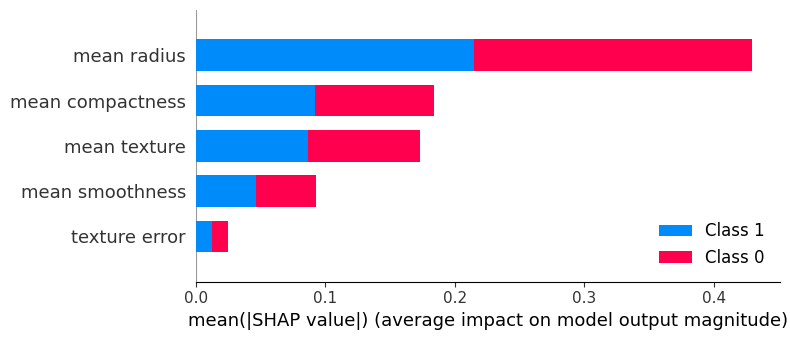

In [20]:
# run SHAP with background data and masker
explainer = shap.TreeExplainer(model=model_breastcancer_sel, data=shap.maskers.Independent(X_test_sel, max_samples=len(X_test_sel)), model_output="probability")

shap_values = explainer(X_test_sel)

# round values and add feature names for plotting
shap_values.data = X_test_sel.round(4) 

#NOTE: the new SHAP package is still a bit buggy.
#      the returned dimensions for the shaply value
#      matrix are swapped. Hence, we need to put
#      then into correct order first.
shap_values.values = list(np.transpose(shap_values.values,(2,0,1)))

print('Features matrix - # samples: {}, # features: {}'.format(X_test_sel.shape[0], X_test_sel.shape[1]))
print('SHAP values matrix - # samples: {}, # features: {}'.format(shap_values.values[0].shape[0], shap_values.values[0].shape[1]))

shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    plot_type='bar')